# 5.Método Cadena Markov-Monte Carlo (MCMC)

In [1]:
using LinearAlgebra
using BenchmarkTools
using SparseArrays
using Random
using Distributions

using Plots
using PyCall
using DataFrames

## Implementación de la función que construye el sistema de ecuaciones de prueba $Ax = b$

In [2]:
function matriz_dispersa(n)
    e = ones(n)
    n2 =Int(n/2)
    diags = [-1,0,1]
    A = Matrix(spdiagm(-1 => -ones(n-1),0 => 3*ones(n),1 => -ones(n-1)))
    c = spdiagm(0 => ones(n)/2)
    ab = [x for x=1:n]
    ba = [(n+1)-x for x=1:n]
    c = Matrix(permute(c, ba, ab))

    A = A + c
    A[n2+1,n2] = -1
    A[n2,n2+1] = -1
    
    b = zeros(n,1)
    b[1] = 2.5
    b[n] = 2.5
    b[2:n-1] .= [1.5]
    b[n2:n2+1] .= [1]
    return A,b
end

matriz_dispersa (generic function with 1 method)

### Evaluación de parámetros

In [3]:

function preparametros(A,b,ϵ,δ)
    M = diagm(0 => diag(A))
    N = M-A
    T = inv(M) * N
    
    f = inv(M) * b
    nT, mT = size(T);

    S = fill(0, nT)
    P = fill(0., nT, mT)
    Pa = P
    [S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
    [P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
    Pa = [accumulate(+, P[i, 1:mT]) for i in 1:nT]
    Pi = [1/nT for i in 1:nT];
    Nc = floor((0.6745/δ)^2*((norm(f)^2)/(1-norm(T))^2)) + 1
    return Nc, mT, f, Pa, T, P
end

preparametros (generic function with 1 method)

### Matriz de probabilidad acumulada pre-build con envío de parámetros, type-anotations y view

In [4]:
function mcmc_acc_par_ta(ϵ, Nc, mT, f, Pa, T, P)
    Xs = fill(0., mT)
    for i in 1:mT
        W_0 = 1.0
        for s in 1:Nc
            W = W_0; point = i; X = W_0 * f[i]::Float64
            while abs(W) >= ϵ
                nextpoint  = 1::Int64
                u = rand()
                while u >= Pa[point][nextpoint]::Float64
                    nextpoint = nextpoint + 1::Int64
                end
                    W_new = W *(T[point, nextpoint]/P[point, nextpoint])::Float64
                    X = X + W_new * f[nextpoint]::Float64
                point = nextpoint::Int64
                W = W_new::Float64
            end
        Xs[i] += X::Float64
        end
    end
    Xs = Xs/Nc::Float64
end

mcmc_acc_par_ta (generic function with 1 method)

In [14]:
n = [6, 10, 30, 50]
A,b = matriz_dispersa(n[1])
As = dropzeros(sparse(A))
bs = dropzeros(sparse(b))
ϵ = 0.1
δ = 0.1 
(Nc, mT, f, Pa, T, P) = preparametros(A,b,ϵ,δ)
# println(Nc, mT, f, Pa, T, P)
(Ncs, mTs, fs, Pas, Ts, Ps) = preparametros(As,b,ϵ,δ)
# println(Ncs, mTs, fs, Pas, Ts, Ps)

(8623.0, 6, [0.8333333333333333; 0.5; … ; 0.5; 0.8333333333333333], [[0.0, 0.5, 0.5, 0.5, 0.5, 1.0], [0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0], [0.0, 0.5, 0.5, 1.0, 1.0, 1.0], [0.0, 0.0, 0.5, 0.5, 1.0, 1.0], [0.0, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 1.0], [0.5, 0.5, 0.5, 0.5, 1.0, 1.0]], [0.0 0.3333333333333333 … 0.0 -0.16666666666666666; 0.3333333333333333 0.0 … -0.16666666666666666 0.0; … ; 0.0 -0.16666666666666666 … 0.0 0.3333333333333333; -0.16666666666666666 0.0 … 0.3333333333333333 0.0], [0.0 0.5 … 0.0 0.5; 0.3333333333333333 0.0 … 0.3333333333333333 0.0; … ; 0.0 0.3333333333333333 … 0.0 0.3333333333333333; 0.5 0.0 … 0.5 0.0])

In [16]:
issparse(As)

true

In [17]:
size(A), size(As)

((6, 6), (6, 6))

In [18]:
((Nc, mT, f, Pa, P) == (Ncs, mTs, fs, Pas, Ps))

true

In [19]:
@benchmark mcmc_acc_par_ta($ϵ, $Nc, $mT, $f, $Pa, $T, $P)

BenchmarkTools.Trial: 782 samples with 1 evaluation.
 Range (min … max):  5.585 ms …   8.988 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     6.297 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.390 ms ± 561.170 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▄▄▃▃▂▃▃▁██▃▅▄▃ ▂▄▁▅▂▂ ▂ ▁▂                                  
  ▆██████████████████████████▇▇▇▅▅▆▆▃▄▅▃▅▃▃▂▁▃▄▂▃▂▁▂▂▁▂▂▂▃▁▂▂ ▅
  5.59 ms         Histogram: frequency by time        8.32 ms <

 Memory estimate: 256 bytes, allocs estimate: 2.

In [20]:
@benchmark mcmc_acc_par_ta($ϵ, $Ncs, $mT, $fs, $Pas, $Ts, $Ps)

BenchmarkTools.Trial: 854 samples with 1 evaluation.
 Range (min … max):  5.454 ms …   7.807 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.676 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.851 ms ± 407.923 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▃▆█▅                                                         
  ████▇▇▆▅▄▅▄▅▄▄▄▄▅▅▄▄▅▄▄▃▃▄▄▄▃▄▂▃▃▃▃▄▃▂▃▃▂▃▃▃▂▃▂▂▂▃▁▂▃▂▁▂▂▂▂ ▃
  5.45 ms         Histogram: frequency by time        7.15 ms <

 Memory estimate: 256 bytes, allocs estimate: 2.

In [21]:
X  = @btime mcmc_acc_par_ta($ϵ, $Nc, $mT, $f, $Pa, $T, $P)
Xs = @btime mcmc_acc_par_ta($ϵ, $Ncs, $mTs, $fs, $Pas, $Ts, $Ps)

  5.571 ms (2 allocations: 256 bytes)
  5.469 ms (2 allocations: 256 bytes)


6-element Array{Float64,1}:
 0.9961110045278699
 1.0044649724545927
 1.0038021513480893
 1.0135391991123834
 0.9903700425341339
 0.9856731388671807

In [22]:
X 

6-element Array{Float64,1}:
 0.9976667750527888
 1.010303045825326
 0.9939297203420365
 1.0054971893047027
 1.004462345986564
 0.9982733516306479

In [23]:
norm(b-A*X)

0.06225082879001266

In [24]:
norm(bs-As*Xs)

0.06880030561949972

In [25]:
yJacobiJ = []
yJacobiP = []
n = [6, 10, 30, 50, 100]
ϵ = 0.1
δ = 0.1 
Nc= mT= f= Pa= T= P=0
Ncs= mTs= fs= Pas= Ts= Ps=0
for i = n
    A,b = matriz_dispersa(i)
    As = dropzeros(sparse(A))
    bs = dropzeros(sparse(b))
    ϵ = 0.1
    δ = 0.1 
    (Nc, mT, f, Pa, T, P) = preparametros(A,b,ϵ,δ)
    jP = @benchmark mcmc_acc_par_ta(ϵ, Nc, mT, f, Pa, T, P) seconds=1   
    push!(yJacobiP, jP)
    (Ncs, mTs, fs, Pas, Ts, Ps) = preparametros(As,bs,ϵ,δ)
    jJ = @benchmark mcmc_acc_par_ta(ϵ, Ncs, mTs, fs, Pas, Ts, Ps) seconds=1
    push!(yJacobiJ, jJ)
   

end

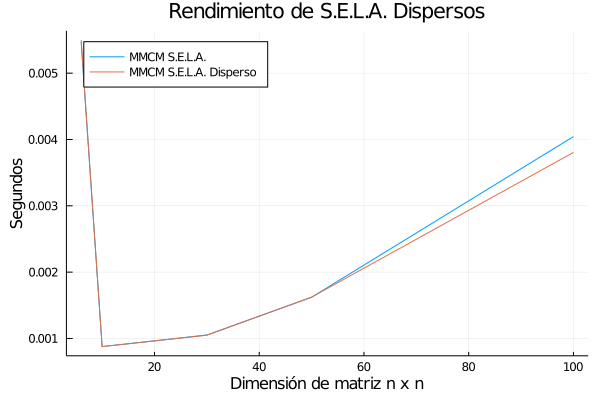

In [26]:
plot(title="Rendimiento de S.E.L.A. Dispersos", legend=:topleft, xaxis="Dimensión de matriz n x n", yaxis="Segundos")
plot!(n, [minimum(yJacobiP[i]).time/10^9  for i=1:size(n)[1]], label="MMCM S.E.L.A.")
plot!(n, [minimum(yJacobiJ[i]).time/10^9  for i=1:size(n)[1]], label="MMCM S.E.L.A. Disperso")